In [1]:
import os
os.environ['HTTP_PROXY'] = "http://127.0.0.1:10809"
os.environ['HTTPS_PROXY'] = "http://127.0.0.1:10809"

In [2]:
import geemap
import ee
Map=geemap.Map()
Map

Map(center=[40, -100], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

In [3]:
# 定义参数
year = '2020'
startDate = year + '-01-01'
endDate = year + '-12-31'

In [4]:
# # 大庆市
# roi = ee.Geometry.Rectangle([123.9355, 45.8362,125.3055, 46.8762])
# # 天津市
# roi = ee.Geometry.Rectangle([115.9244, 38.6272,117.4944,39.6372])
# # 武汉市
# roi = ee.Geometry.Rectangle([113.7393, 29.8642,115.0993, 30.9242])
# # 珠三角
# roi = ee.Geometry.Rectangle([112.7614, 22.2347,114.0514, 23.2547])
# 青藏高原
roi = ee.Geometry.Rectangle([89.8826, 34.6579,91.3626, 35.8279])
Map.addLayer(roi, {}, "roi")
Map.centerObject(roi,7)

In [5]:
## 指数的计算
def water_index(img):
    image = img.clip(roi)
    ndvi=image.normalizedDifference(['B5', 'B4']).rename('NDVI')
    ndwi=image.normalizedDifference(['B3', 'B5']).rename("NDWI")
    mndwi=image.normalizedDifference(['B3', 'B6']).rename("mNDWI")
    ndvi_mndwi = ndvi.subtract(mndwi).rename('ndvi_mndwi')
    cwi=image.select('B3').divide(image.select('B6')).rename("CWI")
    awei = image.expression('B2 + 2.5*B3 - 1.5*(B5+B6) - 0.25*B7',
        {
          'B2': image.select('B2'),
          'B3': image.select('B3'),    
          'B5': image.select('B5'),    
          'B6': image.select('B6'),
          'B7': image.select('B7'),
        }).rename('AWEI')
    ewi = image.expression('(B3 - B5 - B6)/(B3 + B5 + B6)',
        {
          'B3': image.select('B3'),    
          'B5': image.select('B5'),    
          'B6': image.select('B6'),
        }).rename('EWI')
    evi = image.expression('2.5*(B5 - B4)/(B5 + 6*B4 - 7.5*B2 + 1)',
        {
          'B2': image.select('B2'),
          'B4': image.select('B4'),
          'B5': image.select('B5'),    
        }).rename('EVI')
    return image.addBands(ndvi).addBands(ndwi).addBands(mndwi).addBands(cwi).addBands(awei).addBands(ewi).addBands(evi).addBands(ndvi_mndwi)

elevation = ee.Image('USGS/SRTMGL1_003').select('elevation').clip(roi)
def maskSR(img):
    cloudShadowBitMask = (1 << 3)
    cloudsBitMask = (1 << 5)
    snowBitMask = (1 << 4)   
    qa = img.select('pixel_qa')
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0) \
                   .And(qa.bitwiseAnd(cloudsBitMask).eq(0)) \
                   .And(qa.bitwiseAnd(snowBitMask).eq(0))
    azimuth = img.get('SOLAR_AZIMUTH_ANGLE')
    zenith = img.get('SOLAR_ZENITH_ANGLE')
    image = img.lt(0)
    bands = image.select('B2').add(image.select('B3')).add(image.select('B4')).add(image.select('B5')).add(image.select('B6')).add(image.select('B7'))
    outlier = bands.gt(0).remap([0,1],[1,0]).rename('outlier')
    return img.updateMask(mask).updateMask(ee.Terrain.hillShadow(elevation,azimuth,zenith,200,True)).updateMask(outlier)

def maskSR_reverse(img):
    cloudShadowBitMask = (1 << 3)
    cloudsBitMask = (1 << 5)
    snowBitMask = (1 << 4)   
    qa = img.select('pixel_qa')
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0) \
                   .And(qa.bitwiseAnd(cloudsBitMask).eq(0)) \
                   .And(qa.bitwiseAnd(snowBitMask).eq(0))
    image_cloud = img.updateMask(mask.remap([0,1],[1,0]))
    azimuth = img.get('SOLAR_AZIMUTH_ANGLE')
    zenith = img.get('SOLAR_ZENITH_ANGLE')
    image_shadow = img.updateMask(ee.Terrain.hillShadow(elevation,azimuth,zenith,200,True).remap([0,1],[1,0]))
    image = img.lt(0)
    bands = image.select('B2').add(image.select('B3')).add(image.select('B4')).add(image.select('B5')).add(image.select('B6')).add(image.select('B7'))
    image_outlier = img.updateMask(bands.gt(0).rename('outlier'))
    return ee.ImageCollection([image_cloud,image_shadow,image_outlier]).sum()

# 图像可视化参数
visParams = {'bands': ['B5', 'B6', 'B4'],'min': 0,'max': 3000,'gamma': 1.4}

# 数据集

In [6]:
l7 = ee.ImageCollection('LANDSAT/LE07/C01/T1_SR') \
           .select(['B1', 'B2', 'B3', 'B4', 'B5', 'B7','pixel_qa'],['B2', 'B3', 'B4', 'B5', 'B6', 'B7','pixel_qa']) \
           .filterBounds(roi) \
           .filterDate(startDate, endDate)
           
l8 = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
       .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7','pixel_qa']) \
       .filterBounds(roi) \
       .filterDate(startDate, endDate)

landsat_image = l8.merge(l7).map(water_index)
Map.addLayer(l8.map(maskSR).median().clip(roi), visParams,'image mosaic')
print(l7.size().getInfo())
print(l8.size().getInfo())
print(landsat_image.size().getInfo())

120
124
244


# k-mean聚类，RF训练

In [7]:
# # 加载样本集,PearlRiverDeltanew2020_l78,TibetPlateau_new2020_l78,daqing_new2020_l78,tianjin_new2020_l78,wuhan_new2020_l78
samples = ee.FeatureCollection('users/311605001111/tibetan_2020')
print("初始的样本数： ",samples.size().getInfo())

bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7','NDVI','NDWI','mNDWI','CWI','AWEI','EWI','EVI']
# cluster与waterclass的对比
def Compare(feature):
    cluster = ee.Number(feature.get('cluster'))
    waterclass = ee.Number(feature.get('waterclass'))
    ft = ee.Algorithms.If(cluster.eq(waterclass),feature.set({'eq':1}),feature.set({'eq':0}))
    return ft
# k-mean聚类
def k_mean(sampleSET):
    clusterer = ee.Clusterer.wekaKMeans(2).train(sampleSET,bands)
    result = sampleSET.cluster(clusterer)
    right = result.map(Compare).filter(ee.Filter.eq('eq',0))
    error = result.map(Compare).filter(ee.Filter.eq('eq',1))
    filtered_sample = ee.FeatureCollection(ee.Algorithms.If(right.size().gt(error.size()),right,error))
    return filtered_sample

filtered_samples = k_mean(samples)
print("筛选后，剩余的样本数： ",filtered_samples.size().getInfo())

# RandomForest预测使用的波段，分类标签
label = 'waterclass'
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7','NDVI','NDWI','mNDWI','CWI','AWEI','EWI','EVI']

trainedClassifier = ee.Classifier.smileRandomForest(20).train(filtered_samples,label,bands)

初始的样本数：  4705
筛选后，剩余的样本数：  4674


# 图像分类，分为三类：无效像元、非水体、水体

In [8]:
# basemap = ee.Image.constant(0).toFloat().updateMask(img.select('pixel_qa').gt(0)).rename('waterclass')
# img指经过指数计算，但未做云掩膜的图像
def classified_image(img):
    image = maskSR(img).select(bands).classify(trainedClassifier).eq(1).remap([0,1],[1,2]).rename('waterclass').float()
    invalidPixel = maskSR_reverse(img).select('pixel_qa').gt(0).remap([0,1],[1,0]).rename('waterclass').float()
    class_image = ee.ImageCollection([invalidPixel,image]).sum()
    return class_image.set({'system:id':img.get('system:id')})

landsat_images = landsat_image.map(classified_image)

# 筛选出需要（不需要）校正的图像

## 筛选出水体为2km²的图像（无法校正的图像）

In [9]:
#对影像进行分类,计算水体面积
def waterArea(image):
    classified_image = image.select('waterclass').eq(2).rename('waterclass')
    water_area = classified_image.multiply(ee.Image.pixelArea()).divide(1e6)
    waterarea = water_area.reduceRegion(**{
        'reducer': ee.Reducer.sum(),
        'geometry': roi,
        'scale': 200,
        'maxPixels': 1e14,
        'tileScale': 2,
    })
    return image.set({'waterarea': waterarea.get('waterclass')})  

# 需要校正的图像
probable_correct_image = landsat_images.map(waterArea).filter(ee.Filter.gt('waterarea',2))
print(probable_correct_image.size().getInfo())
print(probable_correct_image.aggregate_array('waterarea').getInfo())
# 不需要校正的图像
No_correct_image1 = landsat_images.map(waterArea).filter(ee.Filter.lte('waterarea',2))
print(No_correct_image1.size().getInfo())
print(No_correct_image1.aggregate_array('waterarea').getInfo())

147
[33.769846819715035, 2.2709947617187494, 120.26279626259154, 84.58761536937061, 346.9127380883717, 343.5703872895433, 324.71724751220074, 41.081743521484604, 2.0609785493183215, 2.183810162109377, 112.18326462335375, 2.053562589843752, 10.531374513671897, 59.603733583984315, 317.4136362753819, 308.4264339472576, 284.19641460156345, 39.78825614648438, 3.440857740234375, 42.646630948069884, 43.94174995726098, 40.972438217915126, 24.668066892578107, 34.75783867267157, 20.164514402343787, 78.03221517098682, 864.0706320055166, 1311.4381881093698, 32.87440418359374, 484.7884662982933, 1404.0288587381096, 471.8313595167824, 378.9112854145224, 326.4239028750074, 256.4671076869714, 51.553900218619745, 30.021796794715073, 14.27005876433823, 30.598120083984377, 25.880827203125016, 39.142533235991124, 14.91600761328128, 144.41954618749895, 1123.0893474487068, 1614.7027762419812, 122.86389702801014, 645.1024407590905, 1630.8238773126996, 1137.818629661422, 418.10922582602274, 343.15702280355305

In [10]:
# print(probable_correct_image.filter(ee.Filter.eq('system:index','2_LE07_139035_20200405')).getInfo())
# # print(probable_correct_image.first().getInfo())

{'type': 'ImageCollection', 'bands': [], 'features': [{'type': 'Image', 'bands': [{'id': 'waterclass', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}], 'id': 'LANDSAT/LE07/C01/T1_SR/LE07_139035_20200405', 'properties': {'waterarea': 4.716297970703124, 'system:index': '2_LE07_139035_20200405'}}]}


## 筛选出“occurrence_threshold”在5%--75%的图像（需要校正的图像）

In [11]:
# img指经过指数计算，但未做云掩膜的图像
def occurrence_Histogram(class_image):
    water = class_image.eq(2).selfMask()
    no_data = class_image.eq(0).selfMask()
    occurrence = ee.Image('JRC/GSW1_3/GlobalSurfaceWater').select('occurrence')
    occurrence_water = occurrence.updateMask(water)
    occurrence_no_data = occurrence.updateMask(no_data)
    occurrence_HistogramCount = occurrence_water.reduceRegion(**{
        'reducer': ee.Reducer.histogram(100,1),
        'geometry': roi,
        'scale': 30,
        'bestEffort': True,
        'tileScale': 2,
    })
    return class_image.set({'occurrence_HistogramCount': occurrence_HistogramCount.get('occurrence')})

# img指经过指数计算，但未做云掩膜的图像
def AutomaticCorrection_threshold(class_image):
    histogram = ee.List(ee.Dictionary(class_image.get('occurrence_HistogramCount')).get('histogram'))
    bucketMeans = ee.List(ee.Dictionary(class_image.get('occurrence_HistogramCount')).get('bucketMeans'))
    count_threshold = ee.Number(histogram.reduce(ee.Reducer.sum())).multiply(0.0017)
    index = histogram.map(lambda i : ee.Algorithms.If(ee.Number(i).gte(ee.Number(count_threshold)),ee.Number(i))).removeAll([None]).get(0)
    occurrence_threshold = bucketMeans.get(histogram.indexOf(index))
    return class_image.set({'occurrence_threshold':occurrence_threshold})

In [12]:
occurrence_threshold = probable_correct_image.map(occurrence_Histogram).filter(ee.Filter.neq('occurrence_HistogramCount',None)).map(AutomaticCorrection_threshold)
correct_image = occurrence_threshold.filter(ee.Filter.gte('occurrence_threshold',5)).filter(ee.Filter.lt('occurrence_threshold',75))
print(correct_image.size().getInfo())
print(correct_image.aggregate_array('occurrence_threshold').getInfo())
# print(correct_image.aggregate_array('system:id').getInfo())

80
[8, 6, 5, 8, 42, 9, 6, 9, 46, 12, 7, 9, 5, 6.173698561049032, 10, 9, 9, 8, 12, 7, 7, 7, 8, 10, 9, 7, 5, 6, 11, 14, 38, 8, 8, 6, 9, 13, 15, 9, 11, 9, 6, 5, 8, 10, 8, 6, 5, 6, 6, 10, 5, 9, 9, 18, 7, 5, 13, 6, 5, 5, 7, 9, 10, 11, 5, 43, 6, 13, 7, 8, 8.0627246268734, 8, 8, 9, 5, 6, 6, 5, 7, 10]


In [13]:
No_correct_image2 = occurrence_threshold.filter(ee.Filter.lt('occurrence_threshold',5))
No_correct_image3 = occurrence_threshold.filter(ee.Filter.gte('occurrence_threshold',75))
print(No_correct_image2.size().getInfo())
print(No_correct_image2.aggregate_array('occurrence_threshold').getInfo())
# print(No_correct_image2.aggregate_array('system:id').getInfo())

print(No_correct_image3.size().getInfo())
print(No_correct_image3.aggregate_array('occurrence_threshold').getInfo())
# print(No_correct_image3.aggregate_array('system:id').getInfo())

65
[1, 2, 2, 4, 2, 3, 2, 3, 1, 2, 2, 3, 3, 1, 2, 3, 3, 1, 1, 2, 2, 3, 4.999999999999999, 1, 3, 2.9999999999999996, 2, 3, 4, 2, 4, 2, 2, 4, 4, 4, 4, 3, 2, 2, 3, 2, 2, 2, 3, 4, 3, 4, 2, 2, 2, 3, 4, 3, 4, 3, 3, 3, 2.9999999999999996, 3, 4, 2, 2, 4, 3]
2
[82, 78]


## 最后，获得校正和不需要校正的图像

In [14]:
# 校正图像，correct_image
correct_image = correct_image
print(correct_image.size().getInfo())
# 不需要校正图像
No_correct_image4 = probable_correct_image.map(occurrence_Histogram).filter(ee.Filter.eq('occurrence_HistogramCount',None))
No_correct_image = No_correct_image1.merge(No_correct_image2).merge(No_correct_image3).merge(No_correct_image4)
print(No_correct_image.size().getInfo())

80
164


# 计算水体频率

In [15]:
# img指经过指数计算(需要校正的图像)，但未做云掩膜的图像
def AutomaticCorrection_enhanced(class_image):
    basemap = ee.Image.constant(0).toFloat().updateMask(class_image.gte(0)).rename('waterclass')
    water = class_image.eq(2).selfMask()
    occurrence = ee.Image('JRC/GSW1_3/GlobalSurfaceWater').select('occurrence')
    occurrence_no_data = occurrence.updateMask(class_image.eq(0).selfMask())
    occurrence_threshold = class_image.get('occurrence_threshold')
    occurrence_corrected_water = occurrence_no_data.gte(ee.Number(occurrence_threshold)).selfMask().select('occurrence').rename('waterclass')
    enhanced_water = ee.ImageCollection([basemap,water,occurrence_corrected_water]).sum()
    return enhanced_water

In [16]:
## 水体频率
# 校正图像
correct_waterPixel = correct_image.map(AutomaticCorrection_enhanced).sum()
correct_validPixel = correct_image.map(lambda i : i.select('waterclass').gte(0)).sum()
# 未校正图像
No_Correct_waterPixel = No_correct_image.map(lambda i : i.select('waterclass').eq(2)).sum()
No_Correct_validPixel = No_correct_image.map(lambda i : i.select('waterclass').gt(0)).sum()

In [17]:
# 水体频率
waterPixel = ee.ImageCollection([correct_waterPixel,No_Correct_waterPixel]).sum()
Map.addLayer(waterPixel,{'palette':['white','#3dd633'],'min':0,'max':35},"waterPixelCount")
validPixel = ee.ImageCollection([correct_validPixel,No_Correct_validPixel]).sum()
Map.addLayer(validPixel,{'palette':['white','#e40775'],'min':0,'max':35},"validPixel")
waterfrequency = waterPixel.divide(validPixel).rename('frequency')
Map.addLayer(waterfrequency,{'palette':['white','green'],'min':0,'max':1},"water frequency")
permanentwater = waterfrequency.gte(0.75)
Map.addLayer(permanentwater.selfMask(),{'palette':['blue']},"permanent water")

Text(0.5, 1.0, 'region E/2020')

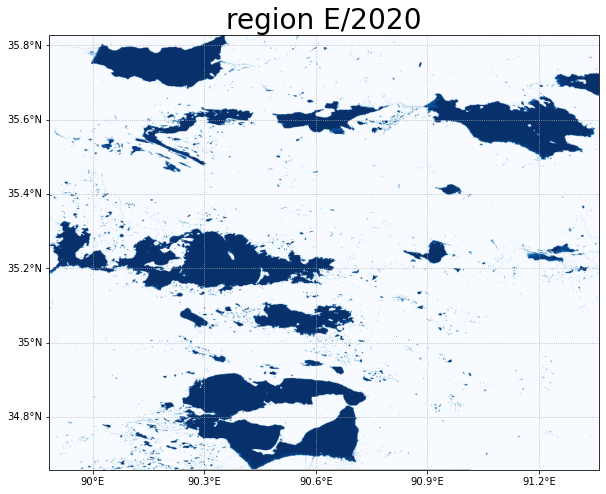

In [18]:
# 水体频率
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee
region = [89.8826, 34.6579,91.3626, 35.8279]
vis = {'min':0, 'max':1}
fig = plt.figure(figsize=(12, 8))
cmap = 'Blues'
ax = cartoee.get_map(waterfrequency, region=region, vis_params=vis,cmap = cmap)
# cartoee.add_colorbar(ax, vis,cmap=cmap,loc="right",label="water frequency", orientation="vertical")
cartoee.add_gridlines(ax, interval=[0.3,0.2], linestyle=":")
ax.set_title(label = 'region E/2020', fontsize=28)

Text(0.5, 1.0, 'region E/2020')

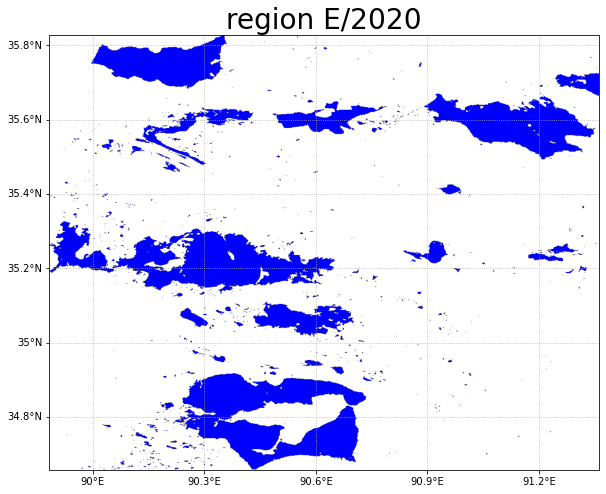

In [19]:
# 永久性水体---v2
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee
region = [89.8826, 34.6579,91.3626, 35.8279]
vis = {'palette':['blue']}
fig = plt.figure(figsize=(12, 8))
ax = cartoee.get_map(permanentwater.selfMask(), region=region, vis_params=vis)
cartoee.add_gridlines(ax, interval=[0.3,0.2], linestyle=":")
ax.set_title(label = 'region E/2020', fontsize=28)

In [ ]:
refer_img = l8.map(maskSR).median().clip(roi).visualize(**visParams)
blend = refer_img.blend(permanentwater.selfMask().visualize(**{'palette':['blue']}))
Map.addLayer(blend, {}, "Blend")

# 其他数据集

In [ ]:
year = '2020'
#### 设置年份
JRC_id = 'JRC/GSW1_3/YearlyHistory/' + year
Maryland_id = 'users/311605001111/Maryland/Maryland_nationwide_' + year
basemap = ee.Image.constant(0).clip(roi).rename('waterclass')
# JRC
JRC = ee.Image(JRC_id).clip(roi).remap([0,1,2,3],[0,0,1,2]).rename('waterclass')
JRC_waterclass = ee.ImageCollection([JRC,basemap]).sum()
# Maryland
Maryland = ee.Image(Maryland_id).clip(roi).select('b1').rename('waterclass')
Maryland_permanent = Maryland.select('waterclass').gte(75).remap([0,1],[0,2]).rename('waterclass')
Maryland_season= ee.ImageCollection([Maryland.gte(25),Maryland.lt(75)]).sum().eq(2)
Maryland_waterclass = ee.ImageCollection([Maryland_permanent,Maryland_season,basemap]).sum()

Map.addLayer(Maryland_waterclass.eq(2).selfMask(),{'palette':['red']},"Maryland permanent")
Map.addLayer(JRC_waterclass.eq(2).selfMask(),{'palette':['green']},"JRC permanent")

In [ ]:
# # JRC permanent waterbody
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee
region = [112.7614, 22.2347,114.0514, 23.2547]
vis = {'palette':['D3D3D3','blue'],'min':0,'max':1}
fig = plt.figure(figsize=(12, 8))
ax = cartoee.get_map(JRC_waterclass.eq(2).selfMask(), region=region, vis_params=vis)
cartoee.add_gridlines(ax, interval=[0.3,0.2], linestyle=":")
ax.set_title(label = 'JRC permanent water(PearlRiverDelta/2020)', fontsize=28)

# # Maryland permanent waterbody
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee
region = [112.7614, 22.2347,114.0514, 23.2547]
vis = {'palette':['D3D3D3','blue'],'min':0,'max':1}
fig = plt.figure(figsize=(12, 8))
ax = cartoee.get_map(Maryland_waterclass.eq(2).selfMask(), region=region, vis_params=vis)
cartoee.add_gridlines(ax, interval=[0.3,0.2], linestyle=":")
ax.set_title(label = 'Maryland permanent water(PearlRiverDelta/2020)', fontsize=23)

In [ ]:
# landsat_images = l8.map(water_index)
landsat_images = landsat_images
waterPixel = landsat_images.map(lambda i : i.select('waterclass').eq(2)).sum()
validPixel = landsat_images.map(lambda i : i.select('waterclass').gt(0)).sum()

# 水体频率
waterfrequency = waterPixel.select('waterclass').divide(validPixel.select('count')).rename('frequency')
Map.addLayer(waterfrequency,{'palette':['white','green'],'min':0,'max':1},"water frequency no")
permanentwater = waterfrequency.gte(0.75)
Map.addLayer(permanentwater.selfMask(),{'palette':['cyan']},"permanent water no")

# 制图

In [ ]:
# 永久性水体---v1
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee
region = [115.9244, 38.6272,117.4944,39.6372]
vis = {'palette':['D3D3D3','blue'],'min':0,'max':1}
fig = plt.figure(figsize=(12, 8))
ax = cartoee.get_map(permanentwater, region=region, vis_params=vis)
cartoee.add_gridlines(ax, interval=[0.3,0.2], linestyle=":")
ax.set_title(label = 'permanent water(daqing/2020)', fontsize=28)

# 永久性水体---v2
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee
region = [112.7614, 22.2347,114.0514, 23.2547]
vis = {'palette':['blue']}
fig = plt.figure(figsize=(12, 8))
ax = cartoee.get_map(permanentwater.selfMask(), region=region, vis_params=vis)
cartoee.add_gridlines(ax, interval=[0.3,0.2], linestyle=":")
ax.set_title(label = 'permanent water(PearlRiverDelta/2020)', fontsize=28)

# 水体频率
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee
region = [115.9244, 38.6272,117.4944,39.6372]
vis = {'min':0, 'max':1}
fig = plt.figure(figsize=(12, 8))
cmap = 'Blues'
ax = cartoee.get_map(waterfrequency, region=region, vis_params=vis,cmap = cmap)
cartoee.add_colorbar(ax, vis,cmap=cmap,loc="right",label="water frequency", orientation="vertical")
cartoee.add_gridlines(ax, interval=[0.3,0.2], linestyle=":")
ax.set_title(label = 'waterbody frequency(Auto-Correction/2020)', fontsize=28)

# 参考影像
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee
region = [123.9355, 45.8362,125.3055, 46.8762]
fig = plt.figure(figsize=(12, 8))
visParams = {'bands': ['B5', 'B6', 'B4'],'min': 0,'max': 3000,'gamma': 1.4}
# use cartoee to get a map
a = l8.filter(ee.Filter.lt('CLOUD_COVER',35)).map(maskSR).median().clip(roi)
ax = cartoee.get_map(a, region=region,vis_params=visParams)
# add gridlines to the map at a specified interval
cartoee.add_gridlines(ax, interval=[0.3,0.2], linestyle=":")
ax.set_title(label = 'refer image(median composite image/2020)', fontsize=28)

# 合成影像
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee

region = [90.8867, 35.4570,91.3632, 35.7387]
fig = plt.figure(figsize=(12, 8))
visParams = {'bands': ['B5', 'B6', 'B4'],'min': 0,'max': 3000,'gamma': 1.4}
# use cartoee to get a map
ax = cartoee.get_map(blend, region=region)
# add gridlines to the map at a specified interval
cartoee.add_gridlines(ax, interval=[0.2,0.1], linestyle=":")
ax.set_title(label = 'Experimental results', fontsize=28)

# 附录

In [ ]:
# # 有效像元比
# def validPercentage(image):
#     mask_area = maskL8sr(image).select('B2').gt(0).multiply(ee.Image.pixelArea()).divide(1e6)
#     area = image.select('B2').gt(0).multiply(ee.Image.pixelArea()).divide(1e6)
#     imageArea = area.reduceRegion(**{
#         'reducer': ee.Reducer.sum(),
#         'geometry': roi,
#         'scale': 30,
#         'maxPixels': 1e14,
#     })
#     mask_imageArea = mask_area.reduceRegion(**{
#         'reducer': ee.Reducer.sum(),
#         'geometry': roi,
#         'scale': 30,
#         'maxPixels': 1e14,
#     })
#     per = ee.Number(100).subtract(ee.Number(mask_imageArea.get('B2')).divide(ee.Number(imageArea.get('B2'))).multiply(100))
#     return image.set({'validPixelPer': per})

# q = lt2_images.map(validPercentage).filter(ee.Filter.lt('validPixelPer',95)).filter(ee.Filter.gte('validPixelPer',5))
# print(q.size().getInfo())
# print(q.aggregate_array('validPixelPer').getInfo())

In [ ]:
# # img指经过指数计算，但未做云掩膜的图像
# def AutomaticCorrection(img):
#     basemap = ee.Image.constant(0).toFloat().updateMask(img.select('B3').gt(0)).rename('waterclass')
#     image = maskSR(img).select(bands).classify(trainedClassifier).eq(1).rename('waterclass')
#     invalidPixel = maskSR_reverse(img).select('B2').gt(0).remap([0,1],[1,0]).rename('waterclass').float()
#     class_image = ee.ImageCollection([invalidPixel,image.remap([0,1],[1,2]).rename('waterclass').float()]).sum()
#     water = class_image.eq(2).selfMask()
#     no_data = class_image.eq(0).selfMask()
#     occurrence = ee.Image('JRC/GSW1_3/GlobalSurfaceWater').select('occurrence')
#     occurrence_water = occurrence.updateMask(water)
#     occurrence_no_data = occurrence.updateMask(no_data)
#     occurrence_HistogramCount = occurrence_water.reduceRegion(**{
#         'reducer': ee.Reducer.histogram(100,1),
#         'geometry': img.geometry(),
#         'scale': 90,
#         'bestEffort': True,
#         'tileScale': 2,
#     })
#     histogram = ee.List(ee.Dictionary(occurrence_HistogramCount.get('occurrence')).get('histogram'))
#     bucketMeans = ee.List(ee.Dictionary(occurrence_HistogramCount.get('occurrence')).get('bucketMeans'))    
#     count_threshold = ee.Number(histogram.reduce(ee.Reducer.sum())).multiply(0.0017)
#     index = histogram.map(lambda i : ee.Algorithms.If(ee.Number(i).gte(ee.Number(count_threshold)),ee.Number(i))).removeAll([None]).get(0)
#     occurrence_threshold = bucketMeans.get(histogram.indexOf(index))
#     occurrence_corrected_water = occurrence_no_data.gte(ee.Number(occurrence_threshold)).selfMask().select('occurrence').rename('waterclass')
#     enhanced_water = ee.ImageCollection([basemap,water,occurrence_corrected_water]).sum()
#     return enhanced_water.set({'occurrence_threshold':occurrence_threshold})

In [ ]:
# # img指经过指数计算，但未做云掩膜的图像
# def AutomaticCorrection_threshold(img):
#     basemap = ee.Image.constant(0).toFloat().updateMask(img.select('B3').gt(0)).rename('waterclass')
#     image = maskSR(img).select(bands).classify(trainedClassifier).eq(1).rename('waterclass')
#     invalidPixel = maskSR_reverse(img).select('B2').gt(0).remap([0,1],[1,0]).rename('waterclass').float()
#     class_image = ee.ImageCollection([invalidPixel,image.remap([0,1],[1,2]).rename('waterclass').float()]).sum()
#     water = class_image.eq(2).selfMask()
#     no_data = class_image.eq(0).selfMask()
#     occurrence = ee.Image('JRC/GSW1_3/GlobalSurfaceWater').select('occurrence')
#     occurrence_water = occurrence.updateMask(water)
#     occurrence_no_data = occurrence.updateMask(no_data)
#     occurrence_HistogramCount = occurrence_water.reduceRegion(**{
#         'reducer': ee.Reducer.histogram(100,1),
#         'geometry': roi,
#         'scale': 30,
#         'bestEffort': True,
#         'tileScale': 2,
#     })
#     histogram = ee.List(ee.Dictionary(occurrence_HistogramCount.get('occurrence')).get('histogram'))
#     bucketMeans = ee.List(ee.Dictionary(occurrence_HistogramCount.get('occurrence')).get('bucketMeans'))    
#     count_threshold = ee.Number(histogram.reduce(ee.Reducer.sum())).multiply(0.0017)
#     index = histogram.map(lambda i : ee.Algorithms.If(ee.Number(i).gte(ee.Number(count_threshold)),ee.Number(i))).removeAll([None]).get(0)
#     occurrence_threshold = bucketMeans.get(histogram.indexOf(index))
#     return img.set({'occurrence_threshold':occurrence_threshold})